## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [1]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "./data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(1000, 1536)

In [6]:
df.head()

,Unnamed: 0,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,Cluster
0,0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007018072064965963, -0.02731654793024063, 0...",0
1,297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.003140551969408989, -0.009995664469897747,...",2
2,296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.01757248118519783, -8.266511576948687e-05,...",0
3,295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.0013932279543951154, -0.011112828738987446...",3
4,294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.01757248118519783, -8.266511576948687e-05,...",0


In [8]:
df.loc[1].Text

"Honestly, I have to admit that I expected a little better. That's not to say that this is bad coffee - in fact it's quite bold without being too acidic, and pretty satisfying overall. I think my main problem is that Wolfgang Puck's name is attached to it, so perhaps it set my expectations a little high. I have a Wolfgang Puck knife set that I adore, and is very high quality for what I paid for it. This coffee was on sale, so it was well worth it also, I just hoped for something that would knock my socks off - which it didn't. I also purchased the Breakfast blend, and Jamaica me crazy at the same time. The breakfast blend was the best, in my opinion, and the jamaican coffee smelled the best, but was the least successful."

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [2]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    4.105691
1    4.191176
2    4.215613
3    4.306590
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

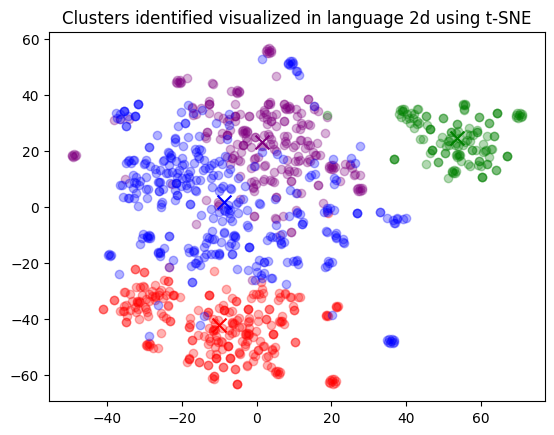

In [3]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci-instruct-beta-v3 to name the clusters, based on a random sample of 6 reviews from that cluster.

In [4]:
import openai
from os import environ as env
from dotenv import load_dotenv

load_dotenv()

# openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_key = env["OPENAI_API_KEY"]

In [5]:
# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=124,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme:  All of the reviews are positive and the customers are satisfied with the product they purchased.
5, Loved these gluten free healthy bars, saved $$ ordering on Amazon:   These Kind Bars are so good and healthy & gluten free.  My daughter ca
1, Should advertise coconut as an ingredient more prominently:   First, these should be called Mac - Coconut bars, as Coconut is the #2
5, very good!!:   just like the runts<br />great flavor, def worth getting<br />I even o
5, Excellent product:   After scouring every store in town for orange peels and not finding an
5, delicious:   Gummi Frogs have been my favourite candy that I have ever tried. of co
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  All of the reviews are about pet food.
2, Messy and apparently undelicious:   My cat is not a huge fan. Sure, she'll lap up the gravy, but leaves th
4, The cats like it:   My 7 cats like this food but it is a little 

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.